# SFHo/SFHx example for O$_2$sclpy

See the O$_2$sclpy documentation at
https://neutronstars.utk.edu/code/o2sclpy for more information.

In [1]:
import o2sclpy
import matplotlib.pyplot as plot
import numpy
import sys

plots=True
if 'pytest' in sys.modules:
    plots=False

Link the O$_2$scl library:

In [2]:
link=o2sclpy.linker()
link.link_o2scl()

Get a copy (a pointer to) the O$_2$scl unit conversion object, which
also allows access to the constant library, then get ħc.

In [3]:
cu=link.o2scl_settings.get_convert_units()
hc=cu.find_unique('hbarc','MeV*fm')
print('ħc = %7.6e\n' % (ħc))

ħc = 1.973270e+02



Create the EOS objects

In [5]:
sfho=o2sclpy.eos_had_rmf(link)
o2sclpy.rmf_load(link,sfho,'SFHo')
sfhx=o2sclpy.eos_had_rmf(link)
o2sclpy.rmf_load(link,sfhx,'SFHx')

Compute nuclear saturation and output the saturation density
and binding energy:

In [6]:
sfho.saturation()
print(('SFHo: n0=%7.6e 1/fm^3, E/A=%7.6e MeV, K=%7.6e MeV, '+
       'M*/M=%7.6e, S=%7.6e MeV, L=%7.6e MeV\n') % 
      (sfho.n0,sfho.eoa*ħc,sfho.comp*ħc,sfho.msom,sfho.esym*ħc,
       sfho.fesym_slope(sfho.n0)*ħc))

sfhx.saturation()
print(('SFHx: n0=%7.6e 1/fm^3, E/A=%7.6e MeV, K=%7.6e MeV, '+
       'M*/M=%7.6e, S=%7.6e MeV, L=%7.6e MeV\n') % 
      (sfhx.n0,sfhx.eoa*ħc,sfhx.comp*ħc,sfhx.msom,sfhx.esym*ħc,
       sfhx.fesym_slope(sfhx.n0)*ħc))

SFHo: n0=1.582415e-01 1/fm^3, E/A=-1.617240e+01 MeV, K=2.452197e+02 MeV, M*/M=7.610394e-01, S=3.123132e+01 MeV, L=4.574056e+01 MeV

SFHx: n0=1.600292e-01 1/fm^3, E/A=-1.614755e+01 MeV, K=2.386347e+02 MeV, M*/M=7.181083e-01, S=2.827230e+01 MeV, L=2.318924e+01 MeV



Baryon density grid in $1/\mathrm{fm}^3$. The O$_2$scl object
`uniform_grid_end_width` is like numpy.arange() but is numerically
stable.

In [7]:
ug_nb=o2sclpy.uniform_grid_end_width.init(link,0.01,0.32,0.01)

Temperature grid in MeV

In [8]:
ug_T=o2sclpy.uniform_grid_end_width.init(link,0.1,10.0,0.1)

Store the EOS in a table3d object

In [9]:
t3d=o2sclpy.table3d(link)
t3d.set_xy_grid('nB',ug_nb,'T',ug_T)

Create a new slice for the energy per baryon

In [10]:
t3d.new_slice('EoA')

Instead of creating new fermion objects, just get the default
neutron and proton from the EOS object. Similarly, we need a
'thermo' object to store the energy density, pressure, and entropy.

In [11]:
n=sfho.get_def_neutron()
p=sfho.get_def_proton()
th=sfho.get_def_thermo()

By default, the O2scl EOS objects work in units of
$\mathrm{fm}^{-1}$, so we multiply by ħc to get MeV.

In [12]:
print('Neutron mass is %7.6e MeV.' % (n.m*ħc))
print('Proton mass is %7.6e MeV.\n' % (p.m*ħc))

Neutron mass is 9.395654e+02 MeV.
Proton mass is 9.382721e+02 MeV.



The solver works much better with an initial guess, so
we store the values of the meson fields 

In [13]:
sigma=0.0
omega=0.0
rho=0.0

The EOS at finite temperature for isospin-symmetric matter, with
equal numbers of neutrons and protons. Our temperature grid is in
MeV, but again the EOS objects expect $\mathrm{fm}^{-1}$ so we have
to divide the temperature by ħc.

In [14]:
for i in range(0,t3d.get_nx()):
    print(i+1,'of',t3d.get_nx())
    # At the lowest temperature point we always need a new initial
    # guess.
    first_point=True
    for j in range(0,t3d.get_ny()):
        n.n=ug_nb[i]/2.0
        p.n=ug_nb[i]/2.0
        # If we're not at the lowest temperature point, use the
        # previous solution to the field equations to generate
        # the next solution.
        if first_point==False:
            sfho.set_fields(sigma,omega,rho)
        sfho.calc_temp_e(n,p,ug_T[j]/ħc,th)
        if first_point==True:
            first_point=False
        ret,sigma,omega,rho=sfho.get_fields()
        # Divide the energy density by the baryon density to
        # get the energy per baryon, and then subtract out the
        # rest mass contribution from both the neutrons and
        # the protons.
        t3d.set(i,j,'EoA',th.ed/ug_nb[i]*ħc-n.m*n.n/ug_nb[i]*ħc-
                p.m*p.n*ħc/ug_nb[i])

1 of 32
2 of 32
3 of 32
4 of 32
5 of 32
6 of 32
7 of 32
8 of 32
9 of 32
10 of 32
11 of 32
12 of 32
13 of 32
14 of 32
15 of 32
16 of 32
17 of 32
18 of 32
19 of 32
20 of 32
21 of 32
22 of 32
23 of 32
24 of 32
25 of 32
26 of 32
27 of 32
28 of 32
29 of 32
30 of 32
31 of 32
32 of 32


Now plot the results. Raw matplotlib works, but o2sclpy has
a couple functions which make it easier. 

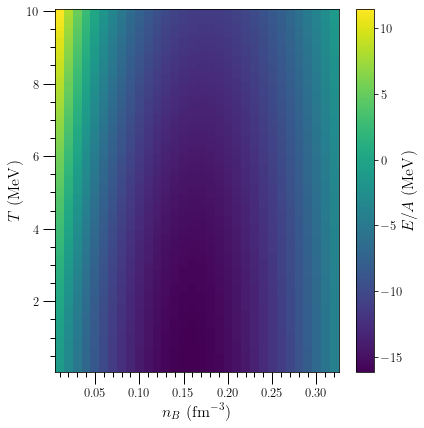

In [15]:
if plots:
    pl=o2sclpy.plotter()
    pl.colbar=True
    pl.xtitle(r'$ n_B~(\mathrm{fm}^{-3}) $')
    pl.ytitle(r'$ T~(\mathrm{MeV}) $')
    pl.ttext(1.25,0.5,r'$ E/A~(\mathrm{MeV}) $',rotation=90)
    pl.den_plot_direct(t3d,'EoA')
    plot.show()

For testing purposes

In [16]:
def test_fun():
    assert numpy.allclose(sfho.n0,0.1582415,rtol=1.0e-4)
    assert numpy.allclose(sfhx.n0,0.1600292,rtol=1.0e-4)
    return